In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Preprocessing imports
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Regression Models imports
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import keras.backend as K
from keras import models
from keras import layers
import xgboost as xgb

## Leitura do Dataset

In [4]:
def read_data():
    
    data = pd.DataFrame()
    for m in range(1,13):
        file = "Dados/DadosBO_2019_"+str(m)+"(ROUBO DE VEÍCULOS).csv"
        aux = pd.read_csv(file)
        data = pd.concat([data, aux], sort=True)
    
    data.index = range(data.shape[0])
    
    data["OCORRENCIA"] = data["DATAOCORRENCIA"] +" "+ data["HORAOCORRENCIA"]
    
    return data.loc[:,["NUMERO_BOLETIM","OCORRENCIA","CIDADE","BAIRRO"]]

In [5]:
data = read_data()
data.head()

,NUMERO_BOLETIM,OCORRENCIA,CIDADE,BAIRRO
0,4590/2018,31/12/2018 22:30,POA,JD COPACABANA
1,8741/2018,31/12/2018 23:30,S.PAULO,VILA CURUCA
2,3396/2018,31/12/2018 22:00,HORTOLANDIA,JARDIM AMANDA
3,5767/2018,31/12/2018 23:20,S.PAULO,GUAIANASES
4,12332/2018,31/12/2018 22:45,CAMPINAS,VILA RUY NOVAES


## Pré-Processamento do Dados

#### removendo dados duplicados e valores faltantes

In [6]:
data = data.dropna()
data = data.drop_duplicates(["NUMERO_BOLETIM"])
data.shape[0]

17161

#### criando novas features

In [8]:
data["OCORRENCIA"] = data.OCORRENCIA.apply(lambda x: x[:6]+"2018"+x[10:])

In [9]:
data["OCORRENCIA"] = pd.to_datetime(data["OCORRENCIA"], dayfirst=True, format="%d/%m/%Y %H:%M")
data.head()

,NUMERO_BOLETIM,OCORRENCIA,CIDADE,BAIRRO
0,4590/2018,2018-12-31 22:30:00,POA,JD COPACABANA
1,8741/2018,2018-12-31 23:30:00,S.PAULO,VILA CURUCA
2,3396/2018,2018-12-31 22:00:00,HORTOLANDIA,JARDIM AMANDA
3,5767/2018,2018-12-31 23:20:00,S.PAULO,GUAIANASES
4,12332/2018,2018-12-31 22:45:00,CAMPINAS,VILA RUY NOVAES


In [10]:
data["DIA_SEMANA"] = data["OCORRENCIA"].dt.day_name()
data["HORA"] = [ d.time().hour + (d.time().minute/60) + (d.time().second/60*60) for d in data["OCORRENCIA"]]

In [11]:
data.head()

,NUMERO_BOLETIM,OCORRENCIA,CIDADE,BAIRRO,DIA_SEMANA,HORA
0,4590/2018,2018-12-31 22:30:00,POA,JD COPACABANA,Monday,22.500000
1,8741/2018,2018-12-31 23:30:00,S.PAULO,VILA CURUCA,Monday,23.500000
2,3396/2018,2018-12-31 22:00:00,HORTOLANDIA,JARDIM AMANDA,Monday,22.000000
3,5767/2018,2018-12-31 23:20:00,S.PAULO,GUAIANASES,Monday,23.333333
4,12332/2018,2018-12-31 22:45:00,CAMPINAS,VILA RUY NOVAES,Monday,22.750000


#### definindo a target feature

In [12]:
def label_y( x ):
    mask1 = (data['CIDADE']==x[0]) & (data['BAIRRO']==x[1]) & (data["DIA_SEMANA"]==x[2]) 
    mask2 = (data["HORA"] >= x[3]) & (data["HORA"]<=x[3]+1)
    y = len(data[mask1 & mask2])-1
    return y

In [13]:
data["Y"] = [ label_y(x) for x in data[["CIDADE","BAIRRO","DIA_SEMANA","HORA"]].values ]

In [14]:
data.head()

,NUMERO_BOLETIM,OCORRENCIA,CIDADE,BAIRRO,DIA_SEMANA,HORA,Y
0,4590/2018,2018-12-31 22:30:00,POA,JD COPACABANA,Monday,22.500000,0
1,8741/2018,2018-12-31 23:30:00,S.PAULO,VILA CURUCA,Monday,23.500000,0
2,3396/2018,2018-12-31 22:00:00,HORTOLANDIA,JARDIM AMANDA,Monday,22.000000,0
3,5767/2018,2018-12-31 23:20:00,S.PAULO,GUAIANASES,Monday,23.333333,0
4,12332/2018,2018-12-31 22:45:00,CAMPINAS,VILA RUY NOVAES,Monday,22.750000,0


#### tratamento de dados categoricos e normalização

In [15]:
data2 = data.loc[:,["CIDADE","BAIRRO","DIA_SEMANA","HORA","Y"]]

encoder = preprocessing.LabelEncoder()

data2["CIDADE"] = encoder.fit_transform(data["CIDADE"])
data2["BAIRRO"] = encoder.fit_transform(data["BAIRRO"])
data2["DIA_SEMANA"] = encoder.fit_transform(data["DIA_SEMANA"])

scaler = preprocessing.StandardScaler()

data2[data2.columns] = scaler.fit_transform(data2)

In [16]:
data2.head()

,CIDADE,BAIRRO,DIA_SEMANA,HORA,Y
0,-0.050299,0.046160,-0.945473,0.995559,-0.587972
1,0.602894,1.246283,-0.945473,1.139441,-0.587972
2,-1.356685,-0.783060,-0.945473,0.923618,-0.587972
3,0.602894,-0.896457,-0.945473,1.115461,-0.587972
4,-2.140516,1.591201,-0.945473,1.031529,-0.587972


## Separação dos Dados em Treino e Teste

In [185]:
X = data2.loc[:,["CIDADE","BAIRRO","DIA_SEMANA","HORA"]]
y = data2["Y"].values

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Modelos de Regressão

In [187]:
def RMSE( y_true, y_predict ):
    n = y_true.shape[0]
    return np.sqrt(np.sum( np.power(y_true-y_predict,2) ) / n)

rmse_models = {}

### BaggingRegressor

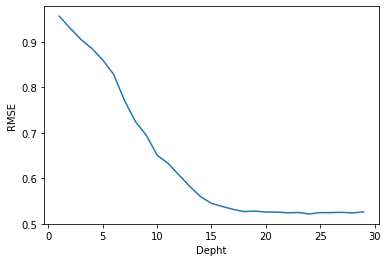

In [188]:
rmse_ = []

for d in range(1,30):
    dt = DecisionTreeRegressor(random_state=42, max_depth = d)
    bc = BaggingRegressor(base_estimator=dt, n_estimators=10, random_state=42)
    bc.fit(X_train, y_train)
    y_pred = bc.predict(X_test)
    rmse_.append(RMSE(y_test,y_pred))

plt.plot( range(1,30), rmse_)
plt.xlabel("Depht")
plt.ylabel("RMSE")
plt.show()

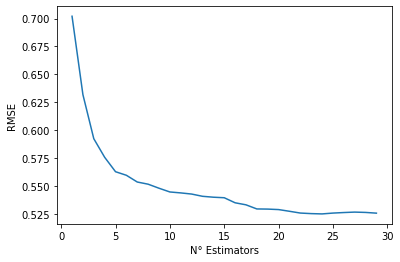

In [189]:
rmse_ = []

for e in range(1,30):
    dt = DecisionTreeRegressor(random_state=42, max_depth = 15)
    bc = BaggingRegressor(base_estimator=dt, n_estimators=e, random_state=42)
    bc.fit(X_train, y_train)
    y_pred = bc.predict(X_test)
    rmse_.append(RMSE(y_test,y_pred))

plt.plot( range(1,30), rmse_)
plt.xlabel("N° Estimators")
plt.ylabel("RMSE")
plt.show()

In [191]:
dt = DecisionTreeRegressor(random_state=42, max_depth = 15)
bc = BaggingRegressor(base_estimator=dt, n_estimators=20, random_state=42)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
r = RMSE(y_test,y_pred)
print("RMSE: ",r)

rmse_models["BaggingRegressor"] = r

RMSE:  0.5289575741298048


### Simple Neural Network

In [192]:
def RMSEK(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [193]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss="mse", metrics=[RMSEK])
    return model

In [194]:
model = build_model()
history = model.fit(X_train, y_train,epochs=30, validation_split=0.2)
rmse_score = model.evaluate(X_test, y_test)[0]

Train on 10982 samples, validate on 2746 samples
Epoch 1/30
10982/10982 [==============================] - 1s 124us/step - loss: 0.9258 - RMSEK: 0.9304 - val_loss: 0.8788 - val_RMSEK: 0.9062
Epoch 2/30
10982/10982 [==============================] - 1s 86us/step - loss: 0.8940 - RMSEK: 0.9101 - val_loss: 0.8543 - val_RMSEK: 0.8907
Epoch 3/30
10982/10982 [==============================] - 1s 91us/step - loss: 0.8676 - RMSEK: 0.8971 - val_loss: 0.8223 - val_RMSEK: 0.8751
Epoch 4/30
10982/10982 [==============================] - 1s 94us/step - loss: 0.8434 - RMSEK: 0.8891 - val_loss: 0.7859 - val_RMSEK: 0.8579
Epoch 5/30
10982/10982 [==============================] - 1s 89us/step - loss: 0.8211 - RMSEK: 0.8746 - val_loss: 0.7674 - val_RMSEK: 0.8494
Epoch 6/30
10982/10982 [==============================] - 1s 102us/step - loss: 0.8053 - RMSEK: 0.8651 - val_loss: 0.7454 - val_RMSEK: 0.8354
Epoch 7/30
10982/10982 [==============================] - 1s 91us/step - loss: 0.7865 - RMSEK: 0.8568 -

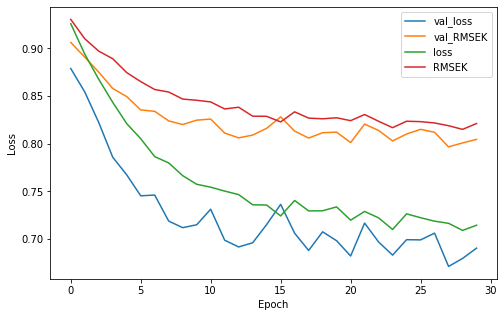

In [195]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [196]:
r = rmse_score
print("RMSE: ",r)

rmse_models["SimpleNeuralNetwork"] = r

RMSE:  0.6913073301063555


### XGBRegressor

In [200]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.1, 
                          learning_rate = 0.2, max_depth = 15, n_estimators = 20)

In [201]:
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)

In [202]:
r = RMSE(y_test,y_pred)
print("RMSE: ",r)

rmse_models["XGBRegressor"] = r

RMSE:  0.7663501895387628


In [211]:
rmse_models.values()

dict_values([0.5289575741298048, 0.6913073301063555, 0.7663501895387628])

## Comparação entre os modelos

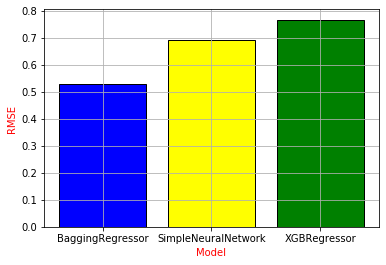

In [228]:
plt.bar(rmse_models.keys(),rmse_models.values(), color=['blue', 'yellow', 'green'], edgecolor='black')
plt.ylabel("RMSE",color="red")
plt.xlabel("Model",color="red")
plt.grid(True)
plt.show()